# Keras

# Setup

In [196]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab 
import statsmodels.api as sm
import seaborn as sns
import os

# Get the Data

In [197]:
def polynomial(x):
    m = 10.
    c = 3.
    f = x*x*m + c
    return f

In [198]:
x = np.linspace(0.1, 10.1, 10001)
y = polynomial(x)

linear = pd.DataFrame({'x': x, 'y': y})

# Test and training sets

In [199]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(linear, test_size=0.25, random_state=42)


In [200]:
# Scale data
# This is very important to ensure that the weights 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.fit_transform(data_test)

In [201]:
x_train = data_train[:, 0]
y_train = data_train[:, 1]

x_test = data_test[:, 0]
y_test = data_test[:, 1]

# Neural Network Model

## Configuration

In [202]:
from keras.callbacks import ModelCheckpoint, TensorBoard
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0,
                         write_graph=True, write_images=True)
# To view:
#     tensorboard --logdir=R:\Dropbox\JupyterNotebooks\Catana\Projects\Keras\Graph\

In [203]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau
# -> Reduce the LR by half (factor) if the accuracy, val_mean_squared_error, is not improved after 3 epochs (patience).
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            mode='auto',
                                            # lr will be reduced when the quantity monitored has stopped decreasing
                                            min_lr=0.00001)

In [204]:
epochs = 20
"""
In general: Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. It's definitely problem dependent.

In general, the models improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge. Try something like 50 and plot number of epochs (x axis) vs. accuracy (y axis). You'll see where it levels out.
"""
batch_size = 32 #256
lr = 0.001 * 10
verbose_flag = 1
validation_split = 0.2
callbacks_list = [tbCallBack, learning_rate_reduction]

## Model architecture

In [205]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
#model.add(Dense(4, input_dim=1, activation='relu'))
model.add(Dense(16, input_dim=1, activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(10, activation='linear'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

## Optimizer

In [206]:
# Define the optimizer
from keras.optimizers import RMSprop, Adam

# Loss function: For regression problems, the mean squared error (MSE) function is commonly used.
# Here the Adam Optimizer is used, which is one of the current default optimizers in deep learning development.
# Adam stands for “Adaptive Moment Estimation” and can be considered as a combination between two other popular
# optimizers AdaGrad and RMSProp.
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

## Build and fit

In [207]:
# Compile the model
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mse"])

In [208]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    verbose=verbose_flag, validation_split=validation_split,
                    callbacks=callbacks_list)

Train on 6000 samples, validate on 1500 samples
Epoch 1/20
6000/6000 [==============================] - 1s 99us/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2/20
6000/6000 [==============================] - 0s 41us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 3/20
6000/6000 [==============================] - 0s 36us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 4/20
6000/6000 [==============================] - 0s 38us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 5/20
6000/6000 [==============================] - 0s 52us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 6.1927e-04 - val_mean_squared_error: 6.1927e-04
Epoch 6/20
6000/6000 [==============================] - 0s 39us/step - loss: 7.1044e-05 - mean_squared_error: 7.1044e-0

### Visualisation

#### Loss curves

Text(0.5, 1.0, 'Loss Curves')

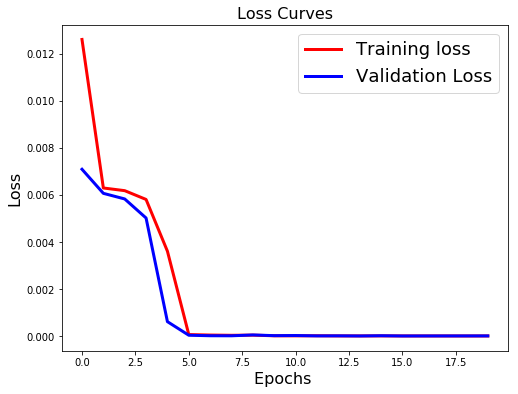

In [209]:
# Loss Curves
plt.figure(figsize=[8, 6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)

#### MSE curves

Text(0.5, 1.0, 'MSE Curves')

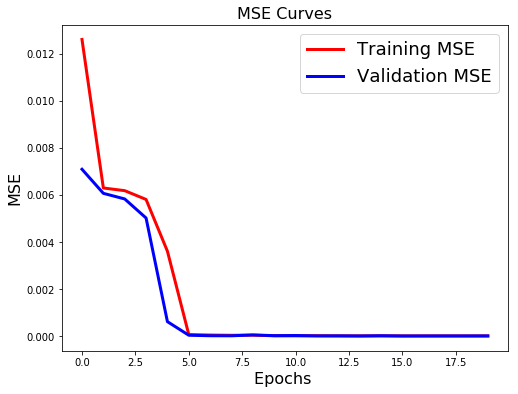

In [210]:

# MSE Curves
plt.figure(figsize=[8, 6])
plt.plot(history.history['mean_squared_error'], 'r', linewidth=3.0)
plt.plot(history.history['val_mean_squared_error'], 'b', linewidth=3.0)
plt.legend(['Training MSE', 'Validation MSE'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.title('MSE Curves', fontsize=16)

### Predictions

In [211]:
predictions = model.predict(x_train, batch_size=batch_size, verbose=0)
df_pred = pd.DataFrame({'true': y_train, 'pred': np.transpose(predictions)[0]}, index=x_train)

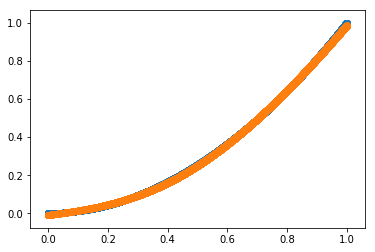

In [212]:
fig = plt.figure()
plt.scatter(x=df_pred.index, y=df_pred.true, label='true')
plt.scatter(x=df_pred.index, y=df_pred.pred, label='pred')

# x= -x_train
# predictions = model.predict(-x_train, batch_size=batch_size, verbose=0)
# plt.scatter(x=x, y= np.transpose(predictions)[0], label='pred2')

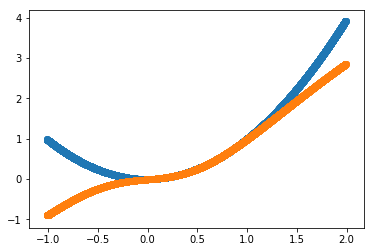

In [213]:
# Look into regions not trained
x = np.linspace(-10, 20, 10001)
y = polynomial(x)

linear = pd.DataFrame({'x': x, 'y': y})
scaled = scaler.transform(linear)

x = scaled[:,0]
y = scaled[:,1]

predictions = model.predict(x, batch_size=batch_size, verbose=0)
plt.scatter(x=x, y=y, label='true')
plt.scatter(x=x, y= np.transpose(predictions)[0], label='pred')

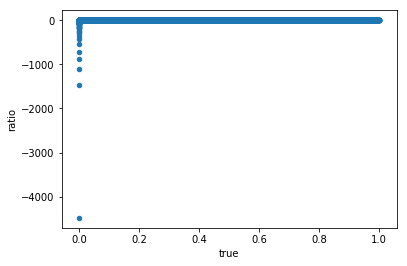

In [214]:
df_pred['ratio'] = df_pred['pred'] / df_pred['true']
df_pred.plot.scatter(x='true', y='ratio')

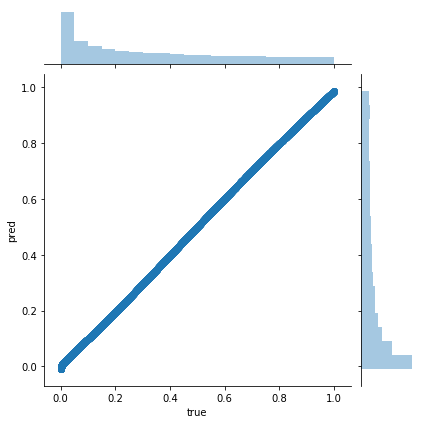

In [215]:
sns.jointplot(x='true', y='pred', data=df_pred)

OverflowError: cannot convert float infinity to integer

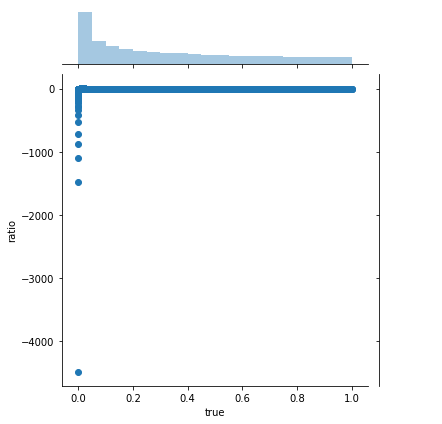

In [216]:
sns.jointplot(x='true', y='ratio', data=df_pred)

# Model 2

In [ ]:

"""
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from matplotlib import pyplot as plt
import seaborn as sns

model = Sequential([Dense(output_dim=4, input_dim=1), Activation("tanh"),
                    Dense(output_dim=4, input_dim=4), Activation("linear"),
                    Dense(output_dim=1, input_dim=4)])

model.compile(loss='mse', optimizer='nadam')

X = np.array([[i] for i in range(100)])
y = np.array([3*x[0]+(x[0]**2)+1 for x in X]) + np.random.normal(0, 1, 100)

model.fit(X, y, nb_epoch=5000)
y_predicted = model.predict(X)
#plt.scatter(X.reshape(-1, 1), y)
plt.plot(X.reshape(-1, 1), y_predicted)
plt.show()
"""